<a href="https://colab.research.google.com/github/RodrigoAgronomia/workshop_esalq/blob/master/python/Classification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install livelossplot

In [2]:
!git clone https://github.com/RodrigoAgronomia/workshop_esalq.git

Cloning into 'workshop_esalq'...
remote: Enumerating objects: 716, done.
remote: Counting objects: 100% (716/716), done.
remote: Compressing objects: 100% (409/409), done.
remote: Total 716 (delta 313), reused 694 (delta 302), pack-reused 0
Receiving objects: 100% (716/716), 296.01 MiB | 42.05 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [3]:
%cd /content/workshop_esalq
!git pull

/content/workshop_esalq
Already up to date.


In [4]:
%cd /content/workshop_esalq/python

/content/workshop_esalq/python


In [0]:
import os
import cv2
import time
import json
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from livelossplot import PlotLosses

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
class CNNModel(torch.nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        
        # Convolution 0
        self.cnn0 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn0 = torch.nn.BatchNorm2d(32)
        self.mxp0 = torch.nn.MaxPool2d(2)
        self.relu0 = torch.nn.ReLU()
        
        # Convolution 1
        self.cnn1 = torch.nn.Conv2d(in_channels=32, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(20)
        self.mxp1 = torch.nn.MaxPool2d(2)
        self.relu1 = torch.nn.ReLU()
        
        # Convolution 2
        self.cnn2 = torch.nn.Conv2d(in_channels=20, out_channels=12, kernel_size=7, stride=1, padding=3)
        self.bn2 = torch.nn.BatchNorm2d(12)
        self.mxp2 = torch.nn.MaxPool2d(2)
        self.relu2 = torch.nn.ReLU()
        
        # Convolution 3
        self.cnn3 = torch.nn.Conv2d(in_channels=12, out_channels=8, kernel_size=9, stride=1, padding=4)
        self.bn3 = torch.nn.BatchNorm2d(8)
        self.mxp3 = torch.nn.MaxPool2d(2)
        self.relu3 = torch.nn.ReLU()
        
        
        self.prep = torch.nn.AdaptiveMaxPool2d(2)
        self.pred = torch.nn.Linear(32, n_classes)
        torch.nn.Softmax

        
    def forward(self, x):
        # Convolution 1
        out = self.relu0(self.mxp0(self.bn0(self.cnn0(x))))
        out = self.relu1(self.mxp1(self.bn1(self.cnn1(out))))
        out = self.relu2(self.mxp2(self.bn2(self.cnn2(out))))
        out = self.relu3(self.mxp3(self.bn3(self.cnn3(out))))
        out = self.prep(out).view(-1, 32)
        out = self.pred(out) 
        return F.log_softmax(out, dim=1)

In [0]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, im_dir, imList):
        data = []
        for idx in range(len(imList)):
            image_name = imList[idx]
            image = cv2.imread(os.path.join(im_dir, image_name))
            image = np.moveaxis(image, 2, 0)
            image = image.astype('float')
            image -= 128
            image /= 35

            label = int(image_name[4]) - 1

            image = torch.from_numpy(image)
            label = torch.from_numpy(np.array([label]))
            data.append([image, label])
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image, label = self.data[idx]
        images = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
        
        return (images, label)

In [0]:
# Directory with the images
im_dir = '../data/class' 

imgs = np.array(sorted(os.listdir(im_dir)))

im_train = np.arange(len(imgs))
im_val = np.random.choice(im_train, 30, replace=False)
im_train = np.setdiff1d(im_train,im_val)


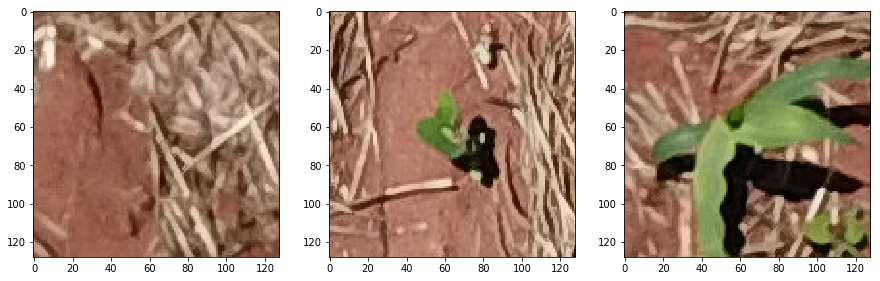

In [10]:
plt.figure(figsize = (15,9))

im0 = cv2.imread(os.path.join(im_dir, imgs[50]))
im1 = cv2.imread(os.path.join(im_dir, imgs[150]))
im2 = cv2.imread(os.path.join(im_dir, imgs[250]))

ims = [im0, im1, im2]
for i in range(len(ims)):
        plt.figure(1)
        plt.subplot(1, 3, i+1)
        plt.imshow(ims[i][:,:,[2,1,0]])


In [0]:
train_dataset =  MyDataset(im_dir, imgs[im_train])
val_dataset =  MyDataset(im_dir, imgs[im_val])

In [0]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=10,
                          shuffle=False,
                          num_workers=0
                         )

In [0]:
n_classes = 3
model = CNNModel(n_classes)
model = model.to(device)
liveloss = PlotLosses()

In [14]:
summary(model, input_size=(n_classes, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 20, 64, 64]          16,020
       BatchNorm2d-6           [-1, 20, 64, 64]              40
         MaxPool2d-7           [-1, 20, 32, 32]               0
              ReLU-8           [-1, 20, 32, 32]               0
            Conv2d-9           [-1, 12, 32, 32]          11,772
      BatchNorm2d-10           [-1, 12, 32, 32]              24
        MaxPool2d-11           [-1, 12, 16, 16]               0
             ReLU-12           [-1, 12, 16, 16]               0
           Conv2d-13            [-1, 8, 16, 16]           7,784
      BatchNorm2d-14            [-1, 8,

In [0]:
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)

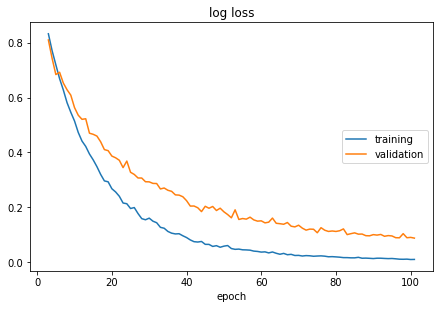

log loss:
training   (min:    0.010, max:    1.095, cur:    0.010)
validation (min:    0.088, max:    1.047, cur:    0.088)
[100] loss: 0.010 time:0.28


In [16]:
min_loss = 1
for epoch in range(101):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, labels.reshape(-1))

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (images, labels) in enumerate(val_loader):
        with torch.no_grad():
          # Obtem o output
          outputs = model(images)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, labels.reshape(-1))

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
      #save the model
      model_file_name = '../data/models/model_3class.pth'
      torch.save(model.state_dict(), model_file_name)
      min_loss = val_loss

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw()
    print('[%d] loss: %.3f time:%.2f' % (epoch, epoch_loss, time_taken))

In [0]:
n_classes = 3
model = CNNModel(n_classes)
model = model.to(device)

# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/models/model_3class.pth', map_location=device))

print('Modelo OK')

Modelo OK


In [0]:
start_time = time.time()

model.eval()
obs = []
preds = []
for i, (images, labels) in enumerate(val_loader):
    obs.append(labels.cpu().data.numpy())
    with torch.no_grad():
      pred = F.softmax(model(images), 1)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs).reshape(-1)
preds = np.concatenate(preds)

          
time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))


time:0.01


In [0]:
np.round(preds,3)

array([[0.981, 0.004, 0.016],
       [0.013, 0.961, 0.027],
       [0.019, 0.014, 0.967],
       [0.004, 0.017, 0.979],
       [0.002, 0.993, 0.005],
       [0.009, 0.009, 0.981],
       [0.977, 0.007, 0.016],
       [0.003, 0.989, 0.008],
       [0.003, 0.014, 0.983],
       [0.986, 0.002, 0.012],
       [0.963, 0.017, 0.02 ],
       [0.977, 0.008, 0.014],
       [0.805, 0.009, 0.186],
       [0.001, 0.994, 0.004],
       [0.952, 0.023, 0.026],
       [0.97 , 0.008, 0.022],
       [0.608, 0.037, 0.355],
       [0.006, 0.985, 0.009],
       [0.003, 0.994, 0.002],
       [0.035, 0.91 , 0.055],
       [0.114, 0.037, 0.849],
       [0.02 , 0.004, 0.977],
       [0.054, 0.062, 0.885],
       [0.022, 0.056, 0.922],
       [0.012, 0.007, 0.981],
       [0.109, 0.015, 0.876],
       [0.983, 0.004, 0.013],
       [0.977, 0.008, 0.015],
       [0.014, 0.949, 0.037],
       [0.008, 0.97 , 0.022]], dtype=float32)

In [0]:
np.stack([obs, preds.argmax(1)]).transpose()

array([[0, 0],
       [1, 1],
       [2, 2],
       [2, 2],
       [1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [2, 2],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1]])